## Import Libraries

In [27]:
import os
import h5py
import numpy as np
import pandas as pd
from pandas import DataFrame
#import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

## Loading Data

In [28]:
# Load data
def load_part_array (sample_dir_path, unit_num, win_len, stride, part_num):
    filename =  'Unit%s_win%s_str%s_part%s.npz' %(str(int(unit_num)), win_len, stride, part_num)
    filepath =  os.path.join(sample_dir_path, filename)
    loaded = np.load(filepath)
    return loaded['sample'], loaded['label']

def load_part_array_merge (npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

def load_array (sample_dir_path, unit_num, win_len, stride):
    filename =  'Unit%s_win%s_str%s_smp10.npz' %(str(int(unit_num)), win_len, stride)
    filepath =  os.path.join(sample_dir_path, filename)
    loaded = np.load(filepath)

    return loaded['sample'].transpose(2, 0, 1), loaded['label']

### Choosing Specific Unitis for Training and Testing

In [29]:
def release_list(a):
   del a[:]
   del a

units_index_train = [16.0, 18.0, 20.0]
units_index_test = [11.0, 14.0, 15.0]

sample_dir_path ='Samples_whole'
sub=10

train_units_samples_lst =[]
train_units_labels_lst = []

for index in units_index_train:
        print("Load data index: ", index)
        sample_array, label_array = load_array (sample_dir_path, index, 50, 1)
        #sample_array, label_array = shuffle_array(sample_array, label_array)
        print("sample_array.shape", sample_array.shape)
        print("label_array.shape", label_array.shape)
        sample_array = sample_array[::sub]
        label_array = label_array[::sub]
        print("sub sample_array.shape", sample_array.shape)
        print("sub label_array.shape", label_array.shape)
        train_units_samples_lst.append(sample_array)
        train_units_labels_lst.append(label_array)
        
sample_array = np.concatenate(train_units_samples_lst)
label_array = np.concatenate(train_units_labels_lst)
print ("samples are aggregated")

release_list(train_units_samples_lst)
release_list(train_units_labels_lst)
train_units_samples_lst =[]
train_units_labels_lst = []
print("Memory released")

    #sample_array, label_array = shuffle_array(sample_array, label_array)
print("samples are shuffled")
print("sample_array.shape", sample_array.shape)
print("label_array.shape", label_array.shape)

print ("train sample dtype", sample_array.dtype)
print("train label dtype", label_array.dtype)

Load data index:  16.0
sample_array.shape (76480, 50, 20)
label_array.shape (76480,)
sub sample_array.shape (7648, 50, 20)
sub label_array.shape (7648,)
Load data index:  18.0
sample_array.shape (89023, 50, 20)
label_array.shape (89023,)
sub sample_array.shape (8903, 50, 20)
sub label_array.shape (8903,)
Load data index:  20.0
sample_array.shape (76767, 50, 20)
label_array.shape (76767,)
sub sample_array.shape (7677, 50, 20)
sub label_array.shape (7677,)
samples are aggregated
Memory released
samples are shuffled
sample_array.shape (24228, 50, 20)
label_array.shape (24228,)
train sample dtype float32
train label dtype float32


### LSTM

In [30]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding
from tensorflow.keras.layers import BatchNormalization, Activation, LSTM, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tcn import TCN

inputs = tf.keras.Input(shape=([50,20]))

#expand_dims = tf.expand_dims(inputs, axis=2)

lstm = tf.keras.layers.LSTM(10, return_sequences=True)(inputs)
lstm = tf.keras.layers.LSTM(10, return_sequences=True)(lstm)
lstm = tf.keras.layers.LSTM(10, return_sequences=True)(lstm)

flatten = tf.keras.layers.Flatten()(lstm)

dense = tf.keras.layers.Dense(100, activation='linear')(flatten)

outputs = tf.keras.layers.Dense(1, activation='linear')(dense)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50, 20)]          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 10)            1240      
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 10)            840       
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 10)            840       
_________________________________________________________________
flatten_4 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101 

In [31]:
history = model.fit(
    sample_array,
    label_array,
    validation_split=0.1,
    epochs=250,
    batch_size=512,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/250
43/43 [==============================] - 4s 36ms/step - loss: 779.7234 - mean_squared_error: 779.7234 - val_loss: 494.4492 - val_mean_squared_error: 494.4492
Epoch 2/250
43/43 [==============================] - 1s 15ms/step - loss: 358.3300 - mean_squared_error: 358.3300 - val_loss: 685.3326 - val_mean_squared_error: 685.3326
Epoch 3/250
43/43 [==============================] - 1s 15ms/step - loss: 351.2151 - mean_squared_error: 351.2151 - val_loss: 647.2549 - val_mean_squared_error: 647.2549
Epoch 4/250
43/43 [==============================] - 1s 15ms/step - loss: 336.2259 - mean_squared_error: 336.2259 - val_loss: 490.2991 - val_mean_squared_error: 490.2991
Epoch 5/250
43/43 [==============================] - 1s 15ms/step - loss: 184.1192 - mean_squared_error: 184.1192 - val_loss: 56.3270 - val_mean_squared_error: 56.3270
Epoch 6/250
43/43 [==============================] - 1s 15ms/step - loss: 61.6376 - mean_squared_error: 61.6376 - val_loss: 6.1925 - val_mean_squared_er

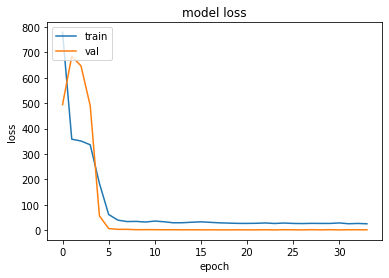

6.116140380725272


In [32]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


from math import sqrt
from sklearn.metrics import mean_squared_error

output_lst = []
truth_lst = []   

for index in units_index_test:
        sample_array, label_array = load_array(sample_dir_path, index, 50, 1)
        sample_array = sample_array[::sub]
        label_array = label_array[::sub]

        y_pred_test = model.predict(sample_array)
        output_lst.append(y_pred_test)
        truth_lst.append(label_array)

output_array = np.concatenate(output_lst)[:, 0]
trytg_array = np.concatenate(truth_lst)

RMSE = sqrt(mean_squared_error(output_array, trytg_array))
print(RMSE)

In [33]:
model.save('WindowingLSTM.h5')